# Automated Patent Landscaping

This notebook walks through the process of creating a patent landscape as described in the paper [Automated Patent Landscaping](AutomatedPatentLandscaping.pdf) (Abood, Feltenberger 2016). The basic outline is:
* load pre-trained word embeddings
* load a seed set of patents and generate the positive and negative training data
* train a deep neural network on the data
* show how to do inference using the model

If you haven't already, please make sure you've setup an environment following the instructions in the [README](README.md) so you have all the necessary dependencies.

## Basic Configuration

In [2]:
import tensorflow as tf
import pandas as pd
import os

# ensures TensorFlow only uses the GPU memory it needs rather than all (the default)
GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
#seed_file = 'seeds/3d_gesture.seed.csv'
seed_name = 'hair_dryer'
seed_file = 'seeds/hair_dryer.seed.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000
gcs_models_url = 'https://console.cloud.google.com/storage/browser/patent_landscapes/models'

## Download Model(s) if Necessary


In [3]:
from word2vec import W2VModelDownload

model_name = '5.9m'
model_download = W2VModelDownload()
model_download.download_w2v_model('patent_landscapes', model_name)
print('Done downloading model {}!'.format(model_name))

Model 5.9m already exists. Using local copy.
Done downloading model 5.9m!


## Load Word2Vec Embeddings

This loads Word2Vec embeddings from a model trained on 5.9 million patent abstracts. Just as a demonstration, this also finds the k most similar words to a given word ranked by closeness in the embedding space. Finally, we use tSNE to visualize the word closeness in 2-dimensional space.

Note that the actual model files are fairly large (e.g., the 5.9m dataset is 760mb per checkpoint), so they are not stored in the Github repository. They're stored in the [patent_landscapes](https://pantheon.corp.google.com/storage/browser/patent_landscapes) Google Cloud Storage bucket under the models/ folder. If you'd like to use them, download the `models` folder and put it into the root repository folder (e.g., if you checked out this repository into the `patent-models` folder, then the `5.9m` model should be in `patent-models/models/5.9m`, for example.

In [3]:
from word2vec import Word2Vec

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [4]:
w2v_runtime.find_similar('hair', 10)

[{'distance': 0.27630660661697637, 'index': 12541, 'word': 'styling'},
 {'distance': 0.32142541152072901, 'index': 10423, 'word': 'scalp'},
 {'distance': 0.36028437798177293, 'index': 12575, 'word': 'hairs'},
 {'distance': 0.38895442679570091, 'index': 3634, 'word': 'cosmetic'},
 {'distance': 0.39621903141812476, 'index': 9330, 'word': 'keratin'},
 {'distance': 0.40511075285155751, 'index': 13313, 'word': 'keratinous'},
 {'distance': 0.4064818428717476, 'index': 1239, 'word': 'skin'},
 {'distance': 0.42916966797624234, 'index': 13269, 'word': 'shampoo'},
 {'distance': 0.43838439284560793, 'index': 12240, 'word': 'cosmetically'},
 {'distance': 0.44125860932789462, 'index': 16618, 'word': 'curler'}]

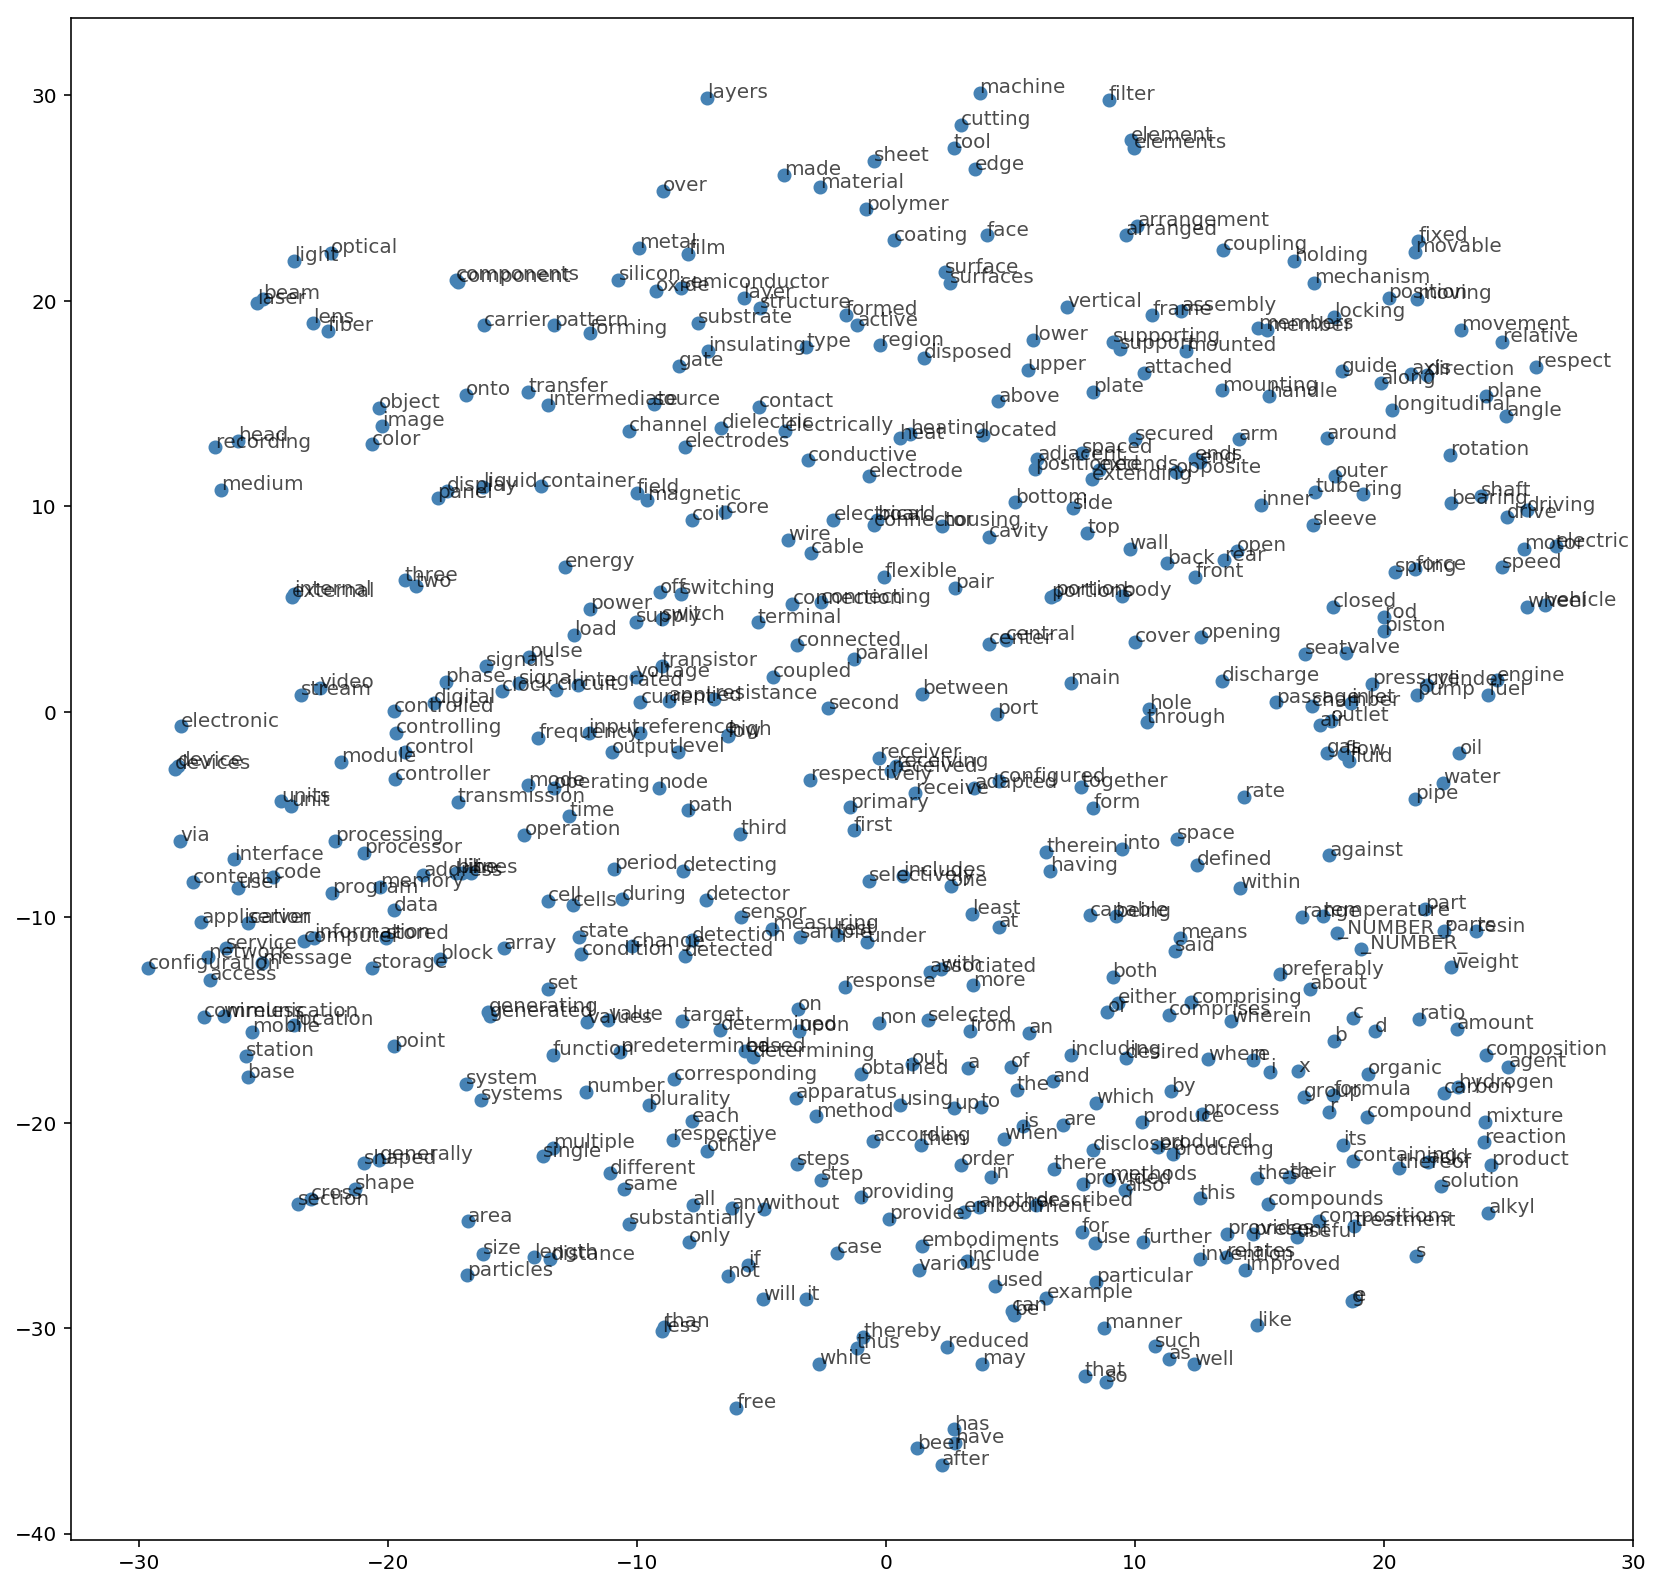

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

w2v_runtime.visualize_embeddings(500)

## Patent Landscape Expansion

This section of the notebook creates an instance of the `PatentLandscapeExpander`, which accesses a BigQuery table of patent data to do the expansion of a provided seed set and produces each expansion level as well as the final training dataset as a Pandas dataframe.

In [4]:
from expansion import PatentLandscapeExpander

expander = PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


This does the actual expansion and displays the head of the final training data dataframe.

In [8]:

training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.load_from_disk_or_do_expansion(seed_file, seed_name)

training_data_full_df.head()


Loading landscape data from filesystem at data/hair_dryer/landscape_data.pkl


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,9072442,US-9072442-B2,34738858,20031231,System and method for displaying an image stream,A system and method may display an image strea...,unused,unused,"DE-3440177-A1,DE-3440177-A1,DE-3440177-A1,DE-3...","A61B2560/045,G06F19/3406,A61B5/7435,A61B5/145,...",AntiSeed
1,5191865,US-5191865-A,17277634,19900927,Engine idle control system for vehicle,An engine idle control system for a vehicle ca...,unused,unused,"US-4492195-A,US-4492195-A,US-4966111-A,US-4966...","Y10T477/675,F02D31/005,Y10T477/675,F02D31/005,...",AntiSeed
2,2013080783,US-2013080783-A1,42805528,20100607,Method for establishing secure network archite...,A method for establishing a secure network arc...,unused,unused,"US-2007206537-A1,US-2007206537-A1,US-200720653...","H04L9/0844,H04L9/0844,H04L12/18,H04L63/061,H04...",AntiSeed
3,2012127125,US-2012127125-A1,46063922,20101119,"Touch panel apparatus, control apparatus and c...","According to an embodiment, a control apparatu...",unused,unused,"US-2009189877-A1,US-2009189877-A1,US-201104346...","G06F3/045,G06F3/0416,G06F3/045,G06F3/0416,G06F...",AntiSeed
4,9047747,US-9047747-B2,46063844,20101119,Dual serial bus interface,An interface protocol for patient monitoring s...,unused,unused,"US-RE39233-E1,US-RE39233-E1,US-RE39233-E1,US-R...","G08B21/02,G06F19/3418,G08B25/005,A61B5/746,A61...",AntiSeed


In [8]:
training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]

### Show some stats about the landscape training data

In [9]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    240
title_text            240
abstract_text         240
claims_text           240
description_text      240
ExpansionLevel        240
refs                  240
cpcs                  240
dtype: int64


Anti-Seed/Negative examples:
publication_number    9826
title_text            9826
abstract_text         9826
claims_text           9826
description_text      9826
ExpansionLevel        9826
refs                  9826
cpcs                  9826
dtype: int64


## Preparing / Transforming Training Data

The following takes the input landscape training dataframe and transforms it into a format readable by TensorFlow and Keras.

In [10]:
import train_data
import tokenizer

td = train_data.LandscapeTrainingData(training_df, w2v_runtime)
td.prepare_training_data(
    training_df.ExpansionLevel,
    training_df.abstract_text,
    training_df.refs,
    training_df.cpcs,
    0.8,
    50000,
    500)


Using TensorFlow backend.


No Keras tokenizer supplied so using vocab size (50000) and series to build new one
No Keras tokenizer supplied so using vocab size (500) and series to build new one
Randomizing training data
Creating NumPy arrays for train/test set out of randomized training data.
Train (embed) data shapes: train: (8052,), train labels shape: (8052,)
Test (embed) data shape: (2014,), test labels shape: (2014,)
doc lengths for embedding layer: median: 102, mean: 104.57625434674615, max: 357
Using sequence length of 357 to pad LSTM sequences.
Training data ready.


### Show some sample training data

In [11]:
pos_idx = -1
neg_idx = -1
for idx in range(0, len(td.prepped_labels)):
    if td.prepped_labels[idx] == 0 and pos_idx < 0:
        pos_idx = idx
    if td.prepped_labels[idx] == 1 and neg_idx < 0:
        neg_idx = idx

    if pos_idx > -1 and neg_idx > -1:
        break

print('Showing positive example (instance #{}).'.format(pos_idx))
td.show_instance_details(pos_idx)
print('\n------------------------------------\n')
print('Showing negative example (instance #{}).'.format(neg_idx))
td.show_instance_details(neg_idx)


Showing positive example (instance #20).

Original: An axially compact hairdryer includes a cylindrical housing having an air inlet and an air outlet at opposite ends thereof. An electric motor is centrally mounted within the housing by a pair of spaced apart support grates secured to the housing perpendicular to the air flow and a cylindrical heating element support body is carried by the support grates and located in concentric spaced relation between the housing and the motor. The heating element is wound about the support element. A fan is operatively connected to the motor for moving air from the inlet to the outlet over the heating element. Air directing vanes are attached to one of the support grates between the motor and the fan.
Tokenized: an axially compact hairdryer includes a cylindrical housing having an air inlet and an air outlet at opposite ends thereof an electric motor is centrally mounted within housing by a pair of spaced apart support grates secured to housing perp

# Train Model

The following cells specify hyperparameters, the neural network architecture (using Keras) and actually trains and tests the model.

The model is generally composed of:
* sequential word embeddings from the patent Abstract of each training instance
* references one-hot encoded into a fully-connected layer
* CPC codes one-hot encoded into a fully-connected layer
* the above three layers concatenated into a final fully-connected layer
* a final, single sigmoid layer with the classification result


### Hyperparameters

In [12]:
batch_size = 32
dropout_pct = 0.2

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128


### Build the Deep Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, ELU
from keras.layers import LSTM, Conv1D, MaxPooling1D, Merge
from keras.layers.merge import concatenate
from keras.layers.core import Dropout
from keras_metrics import precision, recall, f1score

print('Building model graph...')

refs = Sequential()
refs.add(
    Dense(
        256,
        input_dim=td.trainRefsOneHotX.shape[1],
        name='refs',
        activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())
refs.add(Dense(64, activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())

cpcs = Sequential()
cpcs.add(
    Dense(
        32,
        input_dim=td.trainCpcOneHotX.shape[1],
        name='cpcs',
        activation=None))
cpcs.add(Dropout(dropout_pct))
cpcs.add(BatchNormalization())
cpcs.add(ELU())

deep = Sequential()

# Use pre-trained Word2Vec embeddings
embedding_layer = Embedding(td.w2v_runtime.embedding_weights.shape[0],
                            td.w2v_runtime.embedding_weights.shape[1],
                            weights=[td.w2v_runtime.embedding_weights],
                            #input_length=sequence_len,
                            trainable=False,
                            name='embed')
deep.add(embedding_layer)
'''
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
'''
deep.add(LSTM(
    lstm_size,
    dropout=dropout_pct,
    recurrent_dropout=dropout_pct,
    return_sequences=False,
    name='LSTM_1'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name='LSTM_2'))
deep.add(Dense(300, activation=None))
deep.add(Dropout(dropout_pct))
deep.add(BatchNormalization())
deep.add(ELU())


#model = Sequential()
model = deep
#model.add(concatenate([wide, deep], axis=1))
#model.add(Merge([cpcs, deep], mode='concat', concat_axis=1))
#model.add(Dense(64, activation=None))
#model.add(Dropout(dropout_pct))
#model.add(BatchNormalization())
#model.add(ELU())
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

print('Done building graph.')
print(model.summary())

Building model graph...
Done building graph.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, None, 300)         33072000  
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               38700     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 300)               1200      
_________________________________________________________________
elu_8 (ELU)                  (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (N

### Train / Fit the Network

In [29]:
import keras

model_path = os.path.join('data', seed_name, 'model.pb')

if os.path.exists(model_path):
    print('Model exists at {}; loading existing trained model.'.format(model_path))
    model = keras.models.load_model(
        model_path,
        custom_objects={'precision': precision, 'recall': recall, 'fmeasure': f1score})
else:
    print('Model has not been trained yet. Training model.')
    model.fit(x={
            'refs_input': td.trainRefsOneHotX,
            'embed_input': td.padded_train_embed_x,
            'cpcs_input': td.trainCpcOneHotX},
          y=td.trainY,
          batch_size=batch_size,
          epochs=5,
          validation_data=(
              {
                  'refs_input': td.testRefsOneHotX,
                  'cpcs_input': td.testCpcOneHotX,
                  'embed_input': td.padded_test_embed_x},
              td.testY))


Model exists at data/hair_dryer/model.pb; loading existing trained model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, None, 300)         33072000  
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               38700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
elu_4 (ELU)                  (None, 300)               0         
_________________________________________________________________
de

### Evaluate the Model on the Test Set

In [26]:
score, acc, p, r, f1 = model.evaluate(
    x={
        'refs_input': td.testRefsOneHotX,
        'cpcs_input': td.testCpcOneHotX,
        'embed_input': td.padded_test_embed_x
    },
    y=td.testY,
    batch_size=batch_size)

print('')
print('Test score: {:.4f}'.format(score))
print('Test accuracy: {:.4f}'.format(acc))
print('Test p/r (f1): {:.2f}/{:.2f} ({:.2f})'.format(p, r, f1))


2014/2014 [==============================] - 6s     

Test score: 0.0167
Test accuracy: 0.9970
Test p/r (f1): 1.00/1.00 (1.00)


------

# Inference

*NOTE*: the below inference code assumes you've already trained a model _in the currently active kernel_ such that the following variables are already set:
* `model` is the Keras-trained DNN
* `l1_patents_df` is the dataframe returned by the PatentLandscapeExpander

Future iterations will save model checkpoints and allow saving off models and then loading them later just for inference.

### Load Inference Data

This randomly selects a subset of the L1 patents (that we got from reference and CPC expansions) and loads the details (text, CPCs, refs, etc.) from BigQuery.

In [30]:
subset_l1_pub_nums = l1_patents_df[['publication_number']].sample(frac=.20).reset_index(drop=True)
subset_l1_pub_nums.head()

,publication_number
0,US-3988568-A
1,US-3582711-A
2,US-7726461-B2
3,US-3775590-A
4,US-3229703-A


In [49]:
#training_df[training_df.abstract_text.str.contains('learn') & training_df.abstract_text.str.contains('machine')]
#training_df[training_df.abstract_text.str.contains('machine')]

l1_texts = expander.load_training_data_from_pubs(subset_l1_pub_nums)
#l1_texts['label'] = 'Seed'
print(l1_texts.shape)
l1_texts.head()


Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (381, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
(311, 10)


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs
0,2013160316,US-2013160316-A1,48653181,20111128,Hair drying device,A hair drying device including a tube with sel...,unused,unused,"EP-0284690-A2,EP-0284690-A2,EP-0284690-A2,EP-0...","A45D20/00,A45D20/00,A45D20/16,A45D20/12,A45D20..."
1,4023928,US-4023928-A,27015704,19730913,Catalytic fume control device,An electric lamp bulb or electric resistance c...,unused,unused,"US-1678778-A,US-1901038-A,US-2668993-A,US-3001...","A61L9/03,A61L9/03,A61L9/03,A61L9/03,A61L9/03,A..."
2,4328818,US-4328818-A,24732138,19760427,Hand held hair dryer,A domestic hair dryer comprises an axisymetric...,unused,unused,"US-2678376-A,US-2678376-A,US-2817000-A,US-2817...","A45D20/10,A45D20/50,A45D20/10,A45D20/50,A45D20..."
3,6393718,US-6393718-B1,26913827,20000719,Hand held hair dryer,A hand-held hair dryer which includes a negati...,unused,unused,"US-4196343-A,US-4196343-A,US-4258408-A,US-4258...","A45D2200/202,A45D20/12,A45D2200/202,A45D20/12,..."
4,2005108889,US-2005108889-A1,34594761,20031017,Hair dryer attachment,An attachment to a hair dryer is provided incl...,unused,unused,"US-3892247-A,US-3892247-A,US-5612849-A,US-5612...","A45D2200/202,A45D20/122,A45D2200/202,A45D20/12..."


#### Classification of L1

In [93]:

l1_subset = l1_texts[:100][['publication_number', 'abstract_text', 'refs', 'cpcs']]

padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    td.prep_for_inference(l1_subset.abstract_text, l1_subset.refs, l1_subset.cpcs)

predictions = model.predict(
    {
        'embed_input': padded_abstract_embeddings,
        'cpcs_input': cpc_one_hot,
        'refs_input': refs_one_hot
    })

l1_subset['score'] = pd.DataFrame(predictions, columns=['score'])['score']

In [106]:

l1_subset['has_hair'] = l1_subset.abstract_text.str.lower().str.contains('hair')
l1_subset['has_dry'] = l1_subset.abstract_text.str.lower().str.contains('dry')
l1_subset[(l1_subset.score > 0.5) & (l1_subset.has_hair == False) & (l1_subset.has_dry == False)].abstract_text.iloc[0]


'An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or ca

#### Ad-hoc classification
If you want to experiment with ad-hoc classification of data, edit the fields below for abstract text, references, and CPC codes to see how it influences the model's output. Somewhat counter-intuitively, a score closer to 0 means more likely to be an instance of the seed class (e.g., more likely to be about 'hair dryers').

In [107]:
# A conditioner infuser cartridge for use with a dryer attachment having an attachment end for engagement with a hair dryer barrel, an opposite air outlet end and a perforated portion between the ends having at least one air intake, the cartridge configured for engagement near the attachment end and including a conditioner element constructed and arranged for retaining a supply of vaporizable conditioner and a support frame receiving the conditioner element and securing same in the attachment.
# An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or catalytic wrappings may be used on the refractory surfaces which will be radiantly heated by the manually mountable-demountable form of bulb or resistance heating element

adhoc_abstracts = pd.Series(
    [
        'A conditioner infuser cartridge for use with a dryer attachment having an attachment end for engagement with a hair dryer barrel, an opposite air outlet end and a perforated portion between the ends having at least one air intake, the cartridge configured for engagement near the attachment end and including a conditioner element constructed and arranged for retaining a supply of vaporizable conditioner and a support frame receiving the conditioner element and securing same in the attachment.',
    ])
adhoc_refs = pd.Series(
    [
        '',
    ])
adhoc_cpcs = pd.Series(
    [
        '',
    ])

padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    td.prep_for_inference(adhoc_abstracts, adhoc_refs, adhoc_cpcs)

model.predict(
    {
        'embed_input': padded_abstract_embeddings,
        'cpcs_input': cpc_one_hot,
        'refs_input': refs_one_hot
    })


array([[ 0.97424769]], dtype=float32)

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def binary_prediction_idx(score):
    if score < .5:
        return 0
    return 1

def predictions_for_report(patent_model, validX, validY):
    target_names = ['seed', 'antiseed']

    prediction_scores = patent_model.predict(validX)
    predictions = []
    actual_y = []

    for idx in range(0, len(prediction_scores)):
        prediction = prediction_scores[idx]
        actual = validY[idx]
        predictions.append(binary_prediction_idx(prediction[0]))
        actual_y.append(actual)

    return predictions, actual_y, target_names


In [41]:
import pandas as pd
l1_texts_subset = l1_texts.abstract_text[:10000]
l1_texts_subset.reset_index(drop=True, inplace=True)
l1_texts_subset.loc[len(l1_texts_subset)-1] = 'this abstract is about something entirely boring'

l1_labels_subset = l1_texts.label[:10000]
l1_labels_subset.reset_index(drop=True, inplace=True)
l1_labels_subset.loc[len(l1_texts_subset)-1] = 'AntiSeed'

print('Prepping series (tokenization etc.) for training.')
l1_x, l1_y = prep_series_for_training(w2v_runtime, l1_texts_subset, l1_labels_subset)
l1_x = np.array(l1_x)
l1_y = np.array(l1_y)

print('Padding sequences.')
# Convert text idx into padded sequences
l1_x = sequence.pad_sequences(
        l1_x, maxlen=sequence_len, padding='pre', truncating='post')
# Converting labels to binary vectors
#l1_y = to_categorical(l1_y, nb_classes=2)

print('Making predictions')
l1_preds, actual_l1_y, target_names = predictions_for_report(model, l1_x, l1_y)

cr = classification_report(l1_preds, actual_l1_y, target_names=target_names)
cm = confusion_matrix(l1_preds, actual_l1_y)
print(cr)
print(cm)
#l1_texts_subset

Prepping series (tokenization etc.) for training.
Padding sequences.
Making predictions
             precision    recall  f1-score   support

       seed       0.31      1.00      0.47      3070
   antiseed       1.00      0.00      0.00      6930

avg / total       0.79      0.31      0.14     10000

[[3070    0]
 [6929    1]]


In [120]:
#print(l1_preds)
l1_preds_df = pd.DataFrame(l1_preds, columns=['PredictionIdx'])
l1_preds_df['Prediction'] = l1_preds_df.PredictionIdx.apply(label_id_to_text)
l1_preds_df

,PredictionIdx,Prediction
0,1,antiseed
1,1,antiseed
2,1,antiseed
3,0,seed
4,1,antiseed
5,1,antiseed
6,1,antiseed
7,1,antiseed
8,1,antiseed
9,1,antiseed


In [114]:
l1_texts_subset[1]

'The present invention relates to a method for detecting fetal Down syndrome (Trisomy 21), trisomy 13, trisomy 18 and other chromosomal anomalies during prenatal screening by analyzing a dried blood sample from a pregnant woman. More particularly the present invention relates to a method for improving detection efficiency in screening for the anomalies by measuring the amount of the free beta human chorionic gonadotropin (HCG) and nicked or fragmented or aberrant forms of free beta (HCG), all of which are referenced throughout this application as free beta (HCG) in dried blood samples from pregnant women.'

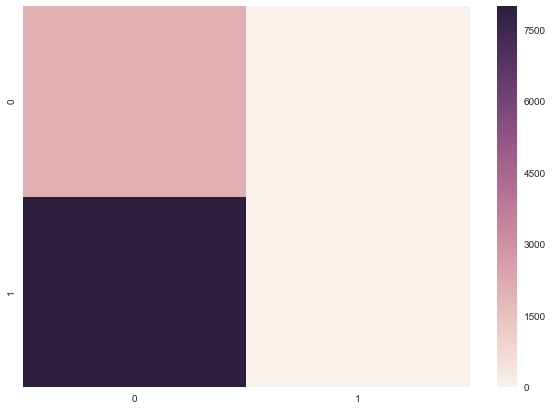

In [93]:
%matplotlib inline

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(cm_df)

In [23]:
import pandas as pd

def make_prediction(patent_model, text, expected_label, max_seq_len, mask_idx=0):
    inf_series = pd.Series([text])
    lab_series = pd.Series([label])

    prepped_train, prepped_labels = \
        prep_series_for_training(
            w2v_runtime=w2v_runtime,
            labels_series=lab_series,
            raw_series_text=inf_series)

    # make sure we have the correct sequence length
    #infX = pad_sequences(prepped_train, maxlen=max_seq_len, value=mask_idx)
    infX = sequence.pad_sequences(
        prepped_train, maxlen=sequence_len, padding='pre', truncating='post')
    #prepped_train = np.array(prepped_train)

    # actually make prediction
    prediction = patent_model.predict(infX)

    return prediction


In [34]:
model.save(filepath='checkpoints/keras_model.ckpt')

In [33]:
text = 'a really boring title that is super long and has nothing to do with the topic that im interested in. but has a bit of stuff about artificial neural networks and things i haven\'t heard of?'
text = 'three dimensional mapping'
#text = l1_texts_subset[10]
label = 'Seed'
prediction = make_prediction(model, text, expected_label=label, max_seq_len=sequence_len)
print('Text: {}'.format(text))
#print('Tokenized/Integerized: {}'.format(prepped_train))
#print('Padded: {}'.format(infX))
print('Prediction: {}'.format(prediction))
print('Predicted Label: {}, Actual Label: {}'.format(label_id_to_text(binary_prediction_idx(prediction)), label))


Text: three dimensional mapping
Prediction: [[ 0.98487407]]
Predicted Label: antiseed, Actual Label: Seed


In [302]:
#oldidx = print_idx
#print_idx = oldidx
#print(model.predict([trainX[print_idx]]))
#tensor_label_to_text(trainY[print_idx])